In [1]:
import pandas as pd
import numpy as np

### Load in Customer Data

In [2]:
customers = pd.read_csv('data/MFG-customers.csv')
customers = customers.loc[:, ['CustomerID', 'City', 'State', 'Country']]
customers['Location'] = customers['State'].fillna(customers['Country']).apply(lambda x: str(x).upper())
customers['City'] = customers['City'].apply(lambda x: str(x).upper())
customers.drop(columns=['State', 'Country'], inplace=True)
 

### Load in Accounts Data

In [3]:
accounts = pd.read_csv('data/MFG-accounts.csv', usecols=['Account_ID', 'Revenue_Class'])

### Load in Invoices Data

In [4]:
invoices = pd.read_csv('data/MFG-invoices.csv', parse_dates=True)
invoices['Date'] = invoices['Date'].apply(pd.Timestamp)
invoices['Month'] = invoices['Date'].apply(lambda x: x.month)
invoices['Year'] = invoices['Date'].apply(lambda x: x.year)
invoices['Day'] = invoices['Date'].apply(lambda x: x.day) 


In [5]:
invoices ['Amount'] = (invoices['Amount'].str.replace(',', '').astype(float)).abs()

In [6]:
invoices['Unit_Price'] = invoices['Unit_Price'].apply(
    lambda x: x.replace(',', '') if isinstance(x, str) else x
).astype(float)
invoices['Amount'] = invoices['Amount'].apply(
    lambda x: x.replace(',', '') if isinstance(x, str) else x
).astype(float)
invoices['Qty'] = invoices['Qty'].apply(
    lambda x: x.replace(',', '') if isinstance(x, str) else x
).astype(float)


### Load in Industry + Press Release Data

In [7]:
industry = pd.read_csv('data/MFG-industry.csv')

In [8]:
press_release = pd.read_csv('data/Press_Release.csv')

In [9]:
press_release['Release Date'] = press_release['Release Date'].apply(pd.Timestamp)
press_release['Month'] = press_release['Release Date'].apply(lambda x: x.month)
press_release['Year'] = press_release['Release Date'].apply(lambda x: x.year)
press_release['Topic_PR'] = press_release['Column1']

In [10]:
press_release.drop(columns=['PR ID', 'Status', 'Last Modified','Premium','Headline', 'Column1'], inplace=True)

In [14]:
press_encoder = Encoder(['Topic_PR'])
press_encoder.fit(press_release)
pr = press_encoder.transform(press_release)
pr = pr.groupby(['Year','Month']).sum().reset_index()

### Create Target Variable

In [15]:
n_days = 90
min_diff_days = 3
repeat=[]
for invoice in invoices.iterrows():
    repeat.append((
        (invoice[1]['CustID'] == invoices['CustID']) 
        & (invoice[1]['Date'] < invoices['Date']) 
        & (invoices['Date'] - invoice[1]['Date'] < pd.Timedelta(n_days, 'd'))
        & (invoices['Date'] - invoice[1]['Date'] > pd.Timedelta(min_diff_days, 'd'))
    ).any())  
    

### Feature Engineering

In [16]:
first_invoice_date = invoices.groupby('CustID')['Date'].min()
customers['First_Invoice'] = first_invoice_date[customers['CustomerID']].values

# days_since_last = invoices.groupby('CustID').apply(lambda x: np.diff(pd.Series.sort_values(x['Date']).values))

In [17]:
total_cust = invoices.groupby('CustID')['Amount'].sum()
invoices['Total_cust'] =  total_cust[invoices['CustID']].values

mean_cust = invoices.groupby('CustID')['Amount'].mean()
invoices['Mean_cust'] =  mean_cust[invoices['CustID']].values

In [21]:
#here I used a merge db
total_rev_class = X.groupby('Revenue_Class')['Amount'].agg('sum')
mean_rev_class = X.groupby('Revenue_Class')['Amount'].agg('mean')

In [ ]:
#X.groupby('Revenue_Class')['CustID']
#X.groupby('Item_ID')['CustID']

In [16]:
#press_release.sort_values(['Year', 'Month']).head(20)

### Merge Data

In [18]:
X = invoices.merge(customers, how='left', left_on=['CustID'], right_on=['CustomerID'])
X = X.merge(accounts, how='left', on=['Account_ID'])
X = X.merge(industry, how='left', left_on=['CustID'],right_on=['CustID'])
X = X.merge(pr, how='left', left_on=['Year','Month'], right_on=['Year','Month'])
X.drop(columns=['CustID', 'CustomerID'], inplace=True)
y = pd.Series(repeat, dtype=int)

In [365]:
#X['ttl_amount_cust'] = total_cust#total_cust.loc[X['CustID'].values].values

In [19]:
cutoff_date = X['Date'].max() - pd.Timedelta(n_days, 'd')

Since we don't have enough data after this date, we can't include it in our training set.

In [20]:
y = y[X['Date'] < cutoff_date]
X = X[X['Date'] < cutoff_date]

X.drop(columns=['Date'], inplace=True)

### Split Data

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [12]:
def clean_nan(X, y):
    X['Item_ID'] = X['Item_ID'].astype(str)
    X['Revenue_Class'] = X['Revenue_Class'].astype(str)
    y = y[~X.isna().any(axis=1)]
    X.dropna(inplace=True)
    return X, y

In [13]:
class Encoder():
    def __init__(self, columns):
        self.encoder = None 
        self.col_names = None
        self.columns = columns
        self.values = []
    
    def fit(self, X):
        X = X.loc[:, self.columns].astype(str)
        self.values = [np.unique(X[col]) for col in X] 
        self.encoder = OneHotEncoder(categories=self.values, handle_unknown='ignore')
        
        self.encoder.fit(X)
        col_names = []
        for column, values in zip(self.columns, self.values):
            for value in values:
                
                col_names.append(f'{column}_{value}') 
        self.col_names = col_names 
        
    def transform(self, X):
        ar = self.encoder.transform(X.loc[:, self.columns].astype(str))
        ar = ar.todense()
        X = X.drop(columns=self.columns)
        for i, col in enumerate(self.col_names):
            X[col] = ar[:, i]
        return X
    

In [22]:
categorical_features = ['Item_ID', 'Month', 'Year', 
                        'Location', 'Revenue_Class',
                        'City', 'Item_ID', 'Account_ID', 
                        'Industry','First_Invoice']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [24]:
X_train, y_train = clean_nan(X_train, y_train)
X_test, y_test = clean_nan(X_test, y_test)

/Users/lulu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/lulu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/lulu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pyda

In [25]:
encoder = Encoder(categorical_features)

In [26]:
encoder.fit(X_train)

In [27]:
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [28]:
X_test.shape

(1200, 566)

In [119]:
X_test.head()

,Qty,Unit_Price,Amount,Day,Total_cust,Mean_cust,Hits,Topic_PR_3D Printing,Topic_PR_Award,Topic_PR_Design,...,First_Invoice_2018-08-10,First_Invoice_2018-08-20,First_Invoice_2018-08-22,First_Invoice_2018-08-24,First_Invoice_2018-08-31,First_Invoice_2018-10-01,First_Invoice_2018-10-11,First_Invoice_2018-10-18,First_Invoice_2018-10-23,First_Invoice_2018-10-25
4480,1.0,100.0,100.0,11,1690.00,99.411765,2134.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10974,3.0,45.0,135.0,10,105740.82,302.982292,745.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10114,1.0,120.0,120.0,16,672.00,74.666667,1464.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2567,5.0,60.0,300.0,29,5535.58,307.532222,1094.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4577,1.0,405.0,405.0,18,18335.00,166.681818,2134.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
X_train.head()

,Qty,Unit_Price,Amount,Day,Total_cust,Mean_cust,Hits,Topic_PR_3D Printing,Topic_PR_Award,Topic_PR_Design,...,First_Invoice_2018-08-10,First_Invoice_2018-08-20,First_Invoice_2018-08-22,First_Invoice_2018-08-24,First_Invoice_2018-08-31,First_Invoice_2018-10-01,First_Invoice_2018-10-11,First_Invoice_2018-10-18,First_Invoice_2018-10-23,First_Invoice_2018-10-25
4386,1.0,195.0,195.0,31,1690.0,99.411765,1441.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8803,6.0,20.0,120.0,22,20505.0,150.772059,864.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9222,2.0,30.0,60.0,13,29362.0,121.330579,1526.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9297,1.0,50.0,50.0,23,50320.0,207.078189,1526.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7408,1.0,15.0,15.0,14,27405.0,128.661972,2007.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modeling

In [30]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score

### Random Forest

In [31]:
rf = RandomForestClassifier(1000)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
log_loss(y_test, rf.predict_proba(X_test)[:, 1])

0.1676528153585446

In [34]:
log_loss(y_test, rf6.predict_proba(X_test)[:, 1])

0.16793170099024618

In [132]:
train_predictions_rf = rf.predict(X_train)
test_predictions_rf = rf.predict_proba(X_test)
train_probas_rf = rf.predict_proba(X_train)
test_probas_rf = rf.predict_proba(X_test)

In [133]:
test_probas_rf = rf.predict_proba(X_test)[:, 1]

In [143]:
threshold = 0.5
model_results_rf = pd.DataFrame(np.column_stack((test_probas_rf,
                                              test_probas_rf >= threshold,
                                              y_test,)))
model_results_rf.columns = ['probabilities','predictions','actuals']
model_results_rf.head()

,probabilities,predictions,actuals
0,0.962,1.0,1.0
1,0.968,1.0,1.0
2,0.067,0.0,0.0
3,0.541,1.0,0.0
4,0.986,1.0,1.0


In [144]:
model_results_rf.shape

(1200, 3)

In [147]:
model_results_rf['index'] = X_test.index

In [148]:
model_results_rf.head()

,probabilities,predictions,actuals,index
0,0.962,1.0,1.0,4480
1,0.968,1.0,1.0,10974
2,0.067,0.0,0.0,10114
3,0.541,1.0,0.0,2567
4,0.986,1.0,1.0,4577


In [146]:
X

,Qty,Unit_Price,Item_ID,Account_ID,Amount,Month,Year,Day,Total_cust,Mean_cust,...,Industry,Hits,Topic_PR_3D Printing,Topic_PR_Award,Topic_PR_Design,Topic_PR_Expansion,Topic_PR_General,Topic_PR_STEM,Topic_PR_Scanning,Topic_PR_Simulation
0,1.0,1695.00,RP-SLA-1,2004040,1695.00,7,2015,1,2706.91,676.727500,...,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,66.91,SHP-MFG,2004210,66.91,7,2015,1,2706.91,676.727500,...,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,23080.00,RP-INJMOLD-1,2004041,23080.00,7,2015,2,36063.68,7212.736000,...,Consumer Product,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,3850.00,RP-INJMOLD-1,2004041,3850.00,7,2015,2,36063.68,7212.736000,...,Consumer Product,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,7830.15,RP-INJMOLD-1,2004041,7830.15,7,2015,2,36063.68,7212.736000,...,Consumer Product,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,1000.00,RP-FDM-1,2004011,1000.00,7,2015,2,17825.00,938.157895,...,Manufacturing Equipment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1.0,570.00,RP-SLS-1,2004050,570.00,7,2015,2,22805.00,186.926230,...,Design,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1.0,495.00,RP-SLS-1,2004050,495.00,7,2015,2,3623.00,258.785714,...,Consumer Product,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0,23.00,SHP-MFG,2004210,23.00,7,2015,2,3623.00,258.785714,...,Consumer Product,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,5.0,15.00,RP-SLS-1,2004050,75.00,7,2015,2,150.00,75.000000,...,Antenna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Gradient Boost

In [104]:
gb = GradientBoostingClassifier(n_estimators=1016, max_depth=4)

In [105]:
cross_val_score(gb, X_train, y_train, cv=3, scoring='neg_log_loss')

array([-0.20448227, -0.22091441, -0.24986345])

In [106]:
gb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1016,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [107]:
log_loss(y_test, gb.predict_proba(X_test)[:, 1])

0.17306185666463775

In [108]:
gb1= GradientBoostingClassifier(n_estimators=4000, max_depth=4)

In [109]:
cross_val_score(gb1, X_train, y_train, cv=3, scoring='neg_log_loss')

array([-0.41111446, -0.45358684, -0.45688848])

In [110]:
gb1.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=4000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [111]:
log_loss(y_test, gb1.predict_proba(X_test)[:, 1])

0.3047276166344045

In [123]:
X_test.columns

Index(['Qty', 'Unit_Price', 'Amount', 'Day', 'Total_cust', 'Mean_cust', 'Hits',
       'Topic_PR_3D Printing', 'Topic_PR_Award', 'Topic_PR_Design',
       ...
       'First_Invoice_2018-08-10', 'First_Invoice_2018-08-20',
       'First_Invoice_2018-08-22', 'First_Invoice_2018-08-24',
       'First_Invoice_2018-08-31', 'First_Invoice_2018-10-01',
       'First_Invoice_2018-10-11', 'First_Invoice_2018-10-18',
       'First_Invoice_2018-10-23', 'First_Invoice_2018-10-25'],
      dtype='object', length=566)

In [ ]:
fig, ax = plt.subplots()
ax.hist(X.loc[y==0,'Day'], bins=20, alpha=0.3, label='0', normed=True)
ax.hist(X.loc[y==1,'Day'], bins=20, alpha=0.3, label='1', normed=True)
ax.legend()

In [139]:
gb1.feature_importances_

array([1.56085014e-02, 7.29538345e-03, 1.37113073e-02, 5.06211782e-02,
       3.53963522e-01, 8.18120796e-02, 4.93210823e-02, 1.09373551e-02,
       9.60090443e-03, 1.07220491e-03, 9.98283785e-03, 0.00000000e+00,
       0.00000000e+00, 3.50915800e-03, 1.07270712e-03, 3.12334164e-05,
       1.80581825e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.03215458e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.67432460e-07, 1.28133726e-03,
       0.00000000e+00, 0.00000000e+00, 1.62845411e-03, 6.50233322e-04,
       6.83301440e-06, 2.00762200e-04, 1.57075316e-04, 2.01611376e-03,
       8.20741840e-05, 8.26194535e-04, 1.08032884e-03, 8.69348170e-05,
       0.00000000e+00, 4.50955219e-03, 1.63817894e-03, 7.11201358e-03,
       4.19360053e-03, 6.10504444e-03, 2.44458020e-03, 6.26918634e-03,
      

No handles with labels found to put in legend.


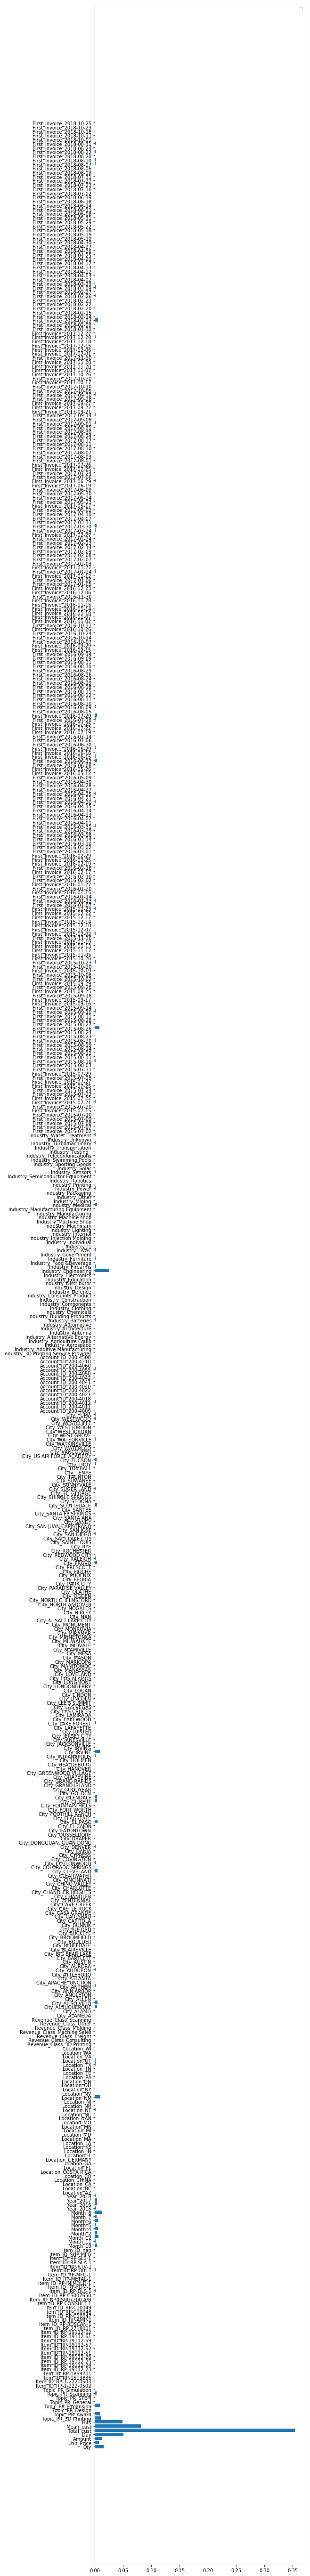

In [141]:
fig, ax = plt.subplots(figsize=(8,100))
ax.barh(X_test.columns, gb1.feature_importances_)
ax.legend()

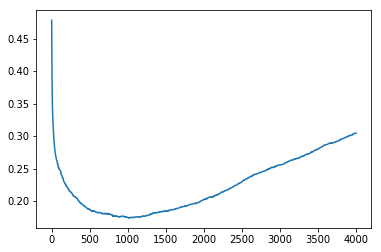

In [112]:
#GradientBoosting
fig, ax = plt.subplots()
ax.plot([log_loss(y_test, y_pred) for y_pred in gb1.staged_predict_proba(X_test)])

In [113]:
np.argmin([log_loss(y_test, y_pred) for y_pred in gb1.staged_predict_proba(X_test)])

1015

In [114]:
train_predictions_gb = gb.predict(X_train)
test_predictions_gb = gb.predict_proba(X_test)
train_probas_gb = gb.predict_proba(X_train)
test_probas_gb = gb.predict_proba(X_test)

In [115]:
test_probas_gb = gb.predict_proba(X_test)[:, 1]

In [116]:
threshold = 0.5
model_results_gb = pd.DataFrame(np.column_stack((test_probas_gb,
                                              test_probas_gb >= threshold,
                                              y_test)))
model_results_gb.columns = ['probabilities','predictions','actuals']
model_results_gb.head()

,probabilities,predictions,actuals
0,0.986982,1.0,1.0
1,0.995827,1.0,1.0
2,0.044747,0.0,0.0
3,0.032304,0.0,0.0
4,0.986184,1.0,1.0


### Logistic Regression

In [60]:
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [61]:
##LOG LOSS
log_loss(y_test, log_reg.predict_proba(X_test)[:, 1])

0.403137026670782

In [62]:
train_predictions = log_reg.predict(X_train)
test_predictions = log_reg.predict_proba(X_test)
train_probas = log_reg.predict_proba(X_train)
test_probas = log_reg.predict_proba(X_test)

In [63]:
test_probas = log_reg.predict_proba(X_test)[:, 1]

In [64]:
threshold = 0.5
model_results = pd.DataFrame(np.column_stack((test_probas,
                                              test_probas >= threshold,
                                              y_test)))
model_results.columns = ['probabilities','predictions','actuals']
model_results.head()

,probabilities,predictions,actuals
0,0.692041,1.0,1.0
1,0.995627,1.0,1.0
2,0.630719,1.0,0.0
3,0.569303,1.0,0.0
4,0.832240,1.0,1.0


### Roc Curve

In [65]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

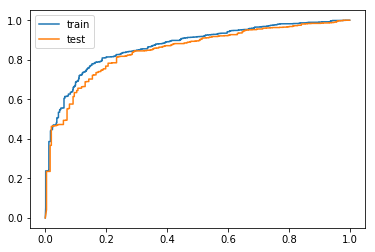

In [66]:
#Logistic Regression
fpr, tpr, threshold = roc_curve(y_train, log_reg.predict_proba(X_train)[:, 1])
plt.plot(fpr, tpr, label='train')
fpr, tpr, threshold = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='test')
plt.legend()

In [67]:
roc_auc_score(model_results.actuals.values, model_results.probabilities.values)

0.8493758790436006

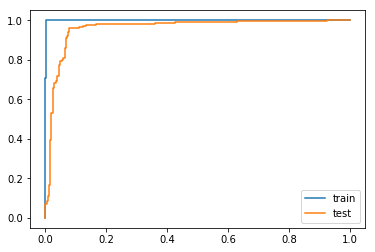

In [68]:
#Gradient Boost
fpr, tpr, threshold = roc_curve(y_train, gb.predict_proba(X_train)[:, 1])
plt.plot(fpr, tpr, label='train')

fpr, tpr, threshold = roc_curve(y_test, gb.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='test')

plt.legend()

In [69]:
roc_auc_score(model_results_gb.actuals.values, model_results_gb.probabilities.values)

0.9595430647645838

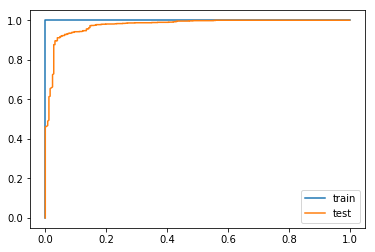

In [71]:
#RandomForest
fpr, tpr, threshold = roc_curve(y_train, rf6.predict_proba(X_train)[:, 1])
plt.plot(fpr, tpr, label='train')
fpr, tpr, threshold = roc_curve(y_test, rf6.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='test')
plt.legend()

In [72]:
roc_auc_score(model_results_rf6.actuals.values, model_results_rf6.probabilities.values)

0.9756128189672495

## Profic Curves

### Logistic Regression

In [73]:
model_results['category'] = 'Other'

In [74]:
model_results.loc[(model_results.predictions == True) & (model_results.actuals == True),'category'] = 'TP'
model_results.loc[(model_results.predictions == True) & (model_results.actuals == False),'category'] = 'FP'
model_results.loc[(model_results.predictions == False) & (model_results.actuals == False),'category'] = 'TN'
model_results.loc[(model_results.predictions == False) & (model_results.actuals == True),'category'] = 'FN'
model_results.head()

,probabilities,predictions,actuals,category
0,0.692041,1.0,1.0,TP
1,0.995627,1.0,1.0,TP
2,0.630719,1.0,0.0,FP
3,0.569303,1.0,0.0,FP
4,0.832240,1.0,1.0,TP


In [75]:
pd.DataFrame(model_results.category.value_counts())

,category
TP,924
FP,210
TN,42
FN,24


### GB

In [76]:
model_results_gb['category'] = 'Other'

In [77]:
model_results_gb.loc[(model_results_gb.predictions == True) & (model_results_gb.actuals == True),'category'] = 'TP'
model_results_gb.loc[(model_results_gb.predictions == True) & (model_results_gb.actuals == False),'category'] = 'FP'
model_results_gb.loc[(model_results_gb.predictions == False) & (model_results_gb.actuals == False),'category'] = 'TN'
model_results_gb.loc[(model_results_gb.predictions == False) & (model_results_gb.actuals == True),'category'] = 'FN'
model_results_gb.head()

,probabilities,predictions,actuals,category
0,0.987039,1.0,1.0,TP
1,0.995730,1.0,1.0,TP
2,0.045950,0.0,0.0,TN
3,0.031954,0.0,0.0,TN
4,0.986011,1.0,1.0,TP


In [78]:
pd.DataFrame(model_results_gb.category.value_counts())

,category
TP,924
TN,217
FP,35
FN,24


In [ ]:
model_results_gb.

### Random Forest

In [79]:
model_results_rf6['category'] = 'Other'

In [80]:
model_results_rf6.loc[(model_results_rf6.predictions == True) & (model_results_rf6.actuals == True),'category'] = 'TP'
model_results_rf6.loc[(model_results_rf6.predictions == True) & (model_results_rf6.actuals == False),'category'] = 'FP'
model_results_rf6.loc[(model_results_rf6.predictions == False) & (model_results_rf6.actuals == False),'category'] = 'TN'
model_results_rf6.loc[(model_results_rf6.predictions == False) & (model_results_rf6.actuals == True),'category'] = 'FN'
model_results_rf6.head()

,probabilities,predictions,actuals,category
0,0.964815,1.0,1.0,TP
1,0.966296,1.0,1.0,TP
2,0.068889,0.0,0.0,TN
3,0.542222,1.0,0.0,FP
4,0.981481,1.0,1.0,TP


In [81]:
pd.DataFrame(model_results_rf6.category.value_counts())

,category
TP,929
TN,204
FP,48
FN,19


In [83]:
cb_matrix = pd.DataFrame([[-5., -20.], [5., 10.]], columns=['PP', 'PN'], index=['AP', 'AN'])
cb_matrix.index.name = 'actual'
cb_matrix.columns.name = 'predicted'

In [84]:
cb_matrix = pd.DataFrame([1., 2., 3., 4.], columns=["category"], index=["TP", "TN", "FP", "FN"])

In [85]:
cb_matrix

,category
TP,1.0
TN,2.0
FP,3.0
FN,4.0


## Clustering

In [89]:
import itertools
import scipy.stats as scs
#from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

from src.cluster_generators import make_gaussian_clusters
from src.multihist import multihist
from src.silhouette import make_silhouette_plot

In [90]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [91]:
X.head()

,Qty,Unit_Price,Item_ID,Account_ID,Amount,Month,Year,Day,Total_cust,Mean_cust,...,Industry,Hits,Topic_PR_3D Printing,Topic_PR_Award,Topic_PR_Design,Topic_PR_Expansion,Topic_PR_General,Topic_PR_STEM,Topic_PR_Scanning,Topic_PR_Simulation
0,1.0,1695.00,RP-SLA-1,200-4040,1695.00,7,2015,1,2706.91,676.7275,...,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,66.91,SHP-MFG,200-4210,66.91,7,2015,1,2706.91,676.7275,...,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,23080.00,RP-INJMOLD-1,200-4041,23080.00,7,2015,2,36063.68,7212.7360,...,Consumer Product,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,3850.00,RP-INJMOLD-1,200-4041,3850.00,7,2015,2,36063.68,7212.7360,...,Consumer Product,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,7830.15,RP-INJMOLD-1,200-4041,7830.15,7,2015,2,36063.68,7212.7360,...,Consumer Product,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
X['Location'].unique()

array(['CO', 'AZ', 'UT', 'CA', 'NAN', 'MA', 'OH', 'NJ', 'PA', 'GERMANY',
       'FL', 'IL', 'TN', 'NE', 'MD', 'IN', 'WA', 'NC', 'GA', 'NM',
       'COSTA RICA', 'MI', 'WI', 'NV', 'NH', 'TE', 'TX', 'KS', 'MN', 'SC',
       'MO', 'CHINA', 'NS', 'OR', 'VA', 'LA', 'PHILIPPINES', 'ON', 'NY',
       'BC'], dtype=object)

In [93]:
X['Account_ID'] = X['Account_ID'].apply(
    lambda x: x.replace('-', '') if isinstance(x, str) else x
).astype(int)

In [94]:
km = KMeans(5)
km.fit(X_train[['Qty', 'Unit_Price']])
labels = km.predict(X_train[['Qty', 'Unit_Price']])

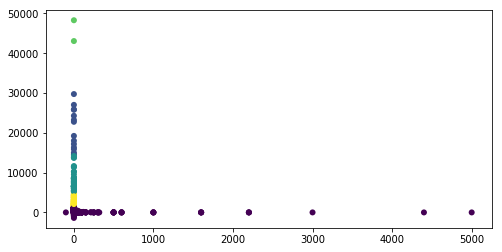

In [95]:
fig, ax = plt.subplots(figsize=(8, 4))

#ax.axis('off')
#ax.axis('equal')
ax.scatter(X_train.values[:,0], X_train.values[:,1], c=labels, linewidths=0)

plt.show()

### Feature importance

In [96]:
from sklearn.linear_model import Lasso

In [97]:
lasso_regularization_strengths = np.logspace(np.log10(0.00001), np.log10(10), num=100)

lasso_regressions = []
for alpha in lasso_regularization_strengths:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    lasso_regressions.append(lasso)



/Users/lulu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/lulu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/lulu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/lulu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not conver

In [98]:
def plot_solution_paths(ax, regressions, columns):
    alphas = [np.log10(ridge.alpha) for ridge in regressions]
    coeffs = np.concatenate([ridge.coef_.reshape(1, -1) 
                             for ridge in regressions])
    for i,idx in enumerate(range(coeffs.shape[1])):
        name = columns[i]
        ax.plot(alphas, coeffs[:, idx], label = name)
    ax.set_xlabel(r"$\log_{10}(\alpha)$")
    ax.set_ylabel("Estiamted Coefficient")
    ax.set_title("Coefficient Paths")
    ax.legend(loc = 5)

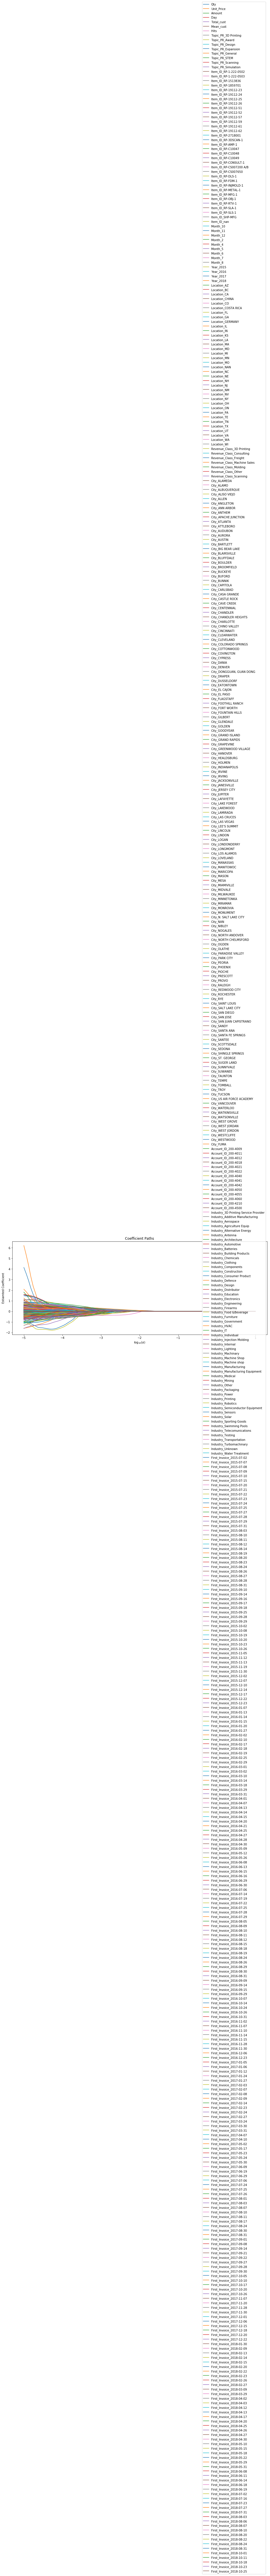

In [99]:
columns = list(X_train.columns)
fig, ax = plt.subplots(figsize=(16, 6))
plot_solution_paths(ax, lasso_regressions, columns)

In [100]:
# Get Feature Importance
coefs = []
for reg in lasso_regressions:
    coefs.append(reg.coef_)
coefs = pd.DataFrame(coefs)
coefs.columns = list(X_train.columns)
np.sum(np.round(np.abs(coefs),3) > 0,axis = 0).sort_values(ascending = False)

Item_ID_RP-SLA-1             58
Day                          58
First_Invoice_2015-07-25     54
First_Invoice_2015-07-23     51
Industry_Engineering         51
City_TEMPE                   49
Location_OH                  47
First_Invoice_2015-07-07     47
First_Invoice_2015-07-29     47
First_Invoice_2017-06-19     46
Industry_Electronics         46
First_Invoice_2015-07-31     46
First_Invoice_2015-08-24     46
Account_ID_200-4050          46
City_ALAMO                   45
Industry_Swimming Pools      45
Industry_Internal            45
Location_NM                  45
Industry_Unknown             44
City_SAN JUAN CAPISTRANO     44
City_MESA                    44
City_IRVINE                  43
Month_8                      42
Month_2                      42
City_GLENDALE                41
City_GILBERT                 41
Revenue_Class_3D Printing    41
Month_10                     41
Topic_PR_Design              40
Location_NJ                  40
                             ..
City_PAR

/Users/lulu/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


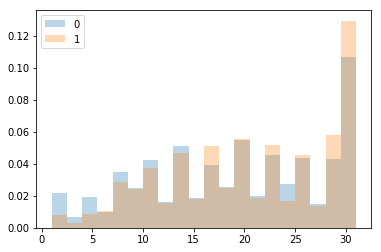

In [101]:
fig, ax = plt.subplots()
ax.hist(X.loc[y==0,'Day'], bins=20, alpha=0.3, label='0', normed=True)
ax.hist(X.loc[y==1,'Day'], bins=20, alpha=0.3, label='1', normed=True)
ax.legend()

In [102]:
y == 0

0        False
1        False
2        False
3        False
4        False
5         True
6        False
7        False
8        False
9         True
10        True
11        True
12        True
13        True
14        True
15        True
16        True
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27        True
28        True
29        True
         ...  
12366    False
12367     True
12368     True
12369     True
12370     True
12371     True
12372     True
12373     True
12374     True
12375    False
12376    False
12377    False
12378    False
12379    False
12380     True
12381    False
12382    False
12383    False
12384    False
12385    False
12386     True
12387     True
12388     True
12389     True
12390     True
12391     True
12392     True
12393     True
12394    False
12395    False
Length: 12396, dtype: bool

In [103]:
coefs

,Qty,Unit_Price,Amount,Day,Total_cust,Mean_cust,Hits,Topic_PR_3D Printing,Topic_PR_Award,Topic_PR_Design,...,First_Invoice_2018-08-10,First_Invoice_2018-08-20,First_Invoice_2018-08-22,First_Invoice_2018-08-24,First_Invoice_2018-08-31,First_Invoice_2018-10-01,First_Invoice_2018-10-11,First_Invoice_2018-10-18,First_Invoice_2018-10-23,First_Invoice_2018-10-25
0,0.000025,8.320028e-06,-7.083263e-06,-0.000758,2.075208e-06,-0.000195,0.000099,0.002513,0.003985,-0.067062,...,0.463660,-0.062535,0.650841,0.070177,-0.092159,0.289798,0.000000,-0.0,-0.670927,-0.0
1,0.000023,8.299528e-06,-6.997993e-06,-0.000737,2.036518e-06,-0.000171,0.000099,0.002825,0.004938,-0.066980,...,0.493390,-0.041169,0.655448,0.072890,-0.082230,0.262513,0.000000,-0.0,-0.689249,-0.0
2,0.000021,8.333361e-06,-6.957362e-06,-0.000720,2.003879e-06,-0.000146,0.000099,0.003055,0.005705,-0.066836,...,0.532179,-0.011782,0.664620,0.074563,-0.072618,0.245810,0.009884,-0.0,-0.705523,-0.0
3,0.000019,8.467606e-06,-6.993816e-06,-0.000705,1.965835e-06,-0.000117,0.000099,0.002899,0.006057,-0.066703,...,0.574293,-0.000000,0.684383,0.086737,-0.044096,0.246430,0.038306,-0.0,-0.708470,-0.0
4,0.000017,8.515779e-06,-6.944463e-06,-0.000693,1.933702e-06,-0.000094,0.000099,0.002989,0.006712,-0.066368,...,0.583514,-0.000000,0.682481,0.087747,-0.025405,0.231926,0.000006,-0.0,-0.726400,-0.0
5,0.000014,8.490548e-06,-6.804626e-06,-0.000686,1.915232e-06,-0.000077,0.000099,0.003200,0.007989,-0.065354,...,0.581173,-0.000000,0.664685,0.083018,-0.023027,0.219642,0.000000,-0.0,-0.740762,-0.0
6,0.000011,8.512896e-06,-6.720402e-06,-0.000667,1.917034e-06,-0.000059,0.000099,0.002724,0.009177,-0.064117,...,0.589433,-0.000000,0.646508,0.081080,-0.006932,0.213701,0.000000,-0.0,-0.729327,-0.0
7,0.000010,8.837491e-06,-6.890049e-06,-0.000641,1.923821e-06,-0.000055,0.000099,0.001993,0.009879,-0.063997,...,0.593404,-0.000000,0.618756,0.081743,-0.000000,0.214363,0.000000,-0.0,-0.701572,-0.0
8,0.000010,9.190410e-06,-7.062395e-06,-0.000616,1.915428e-06,-0.000050,0.000098,0.001129,0.010627,-0.064013,...,0.603558,-0.000000,0.600873,0.086524,0.000000,0.235417,0.000000,-0.0,-0.674804,-0.0
9,0.000009,9.318669e-06,-7.083884e-06,-0.000572,1.910323e-06,-0.000041,0.000098,0.000678,0.012045,-0.064062,...,0.622466,-0.000000,0.590096,0.102020,0.020709,0.259253,0.000000,-0.0,-0.646243,-0.0
